# Part 2 – EMNIST Letters: Convolutional Neural Network
This notebook builds and trains a **CNN** to classify handwritten letters from the EMNIST dataset with TensorFlow/Keras.

## Setup

In [2]:

# !pip install tensorflow tensorflow-datasets scikit-learn matplotlib seaborn --quiet

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

tf.random.set_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12,8)

os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)


## 1. Data Loading & Visualisation

Train: (88800, 28, 28)  Test: (14800, 28, 28)


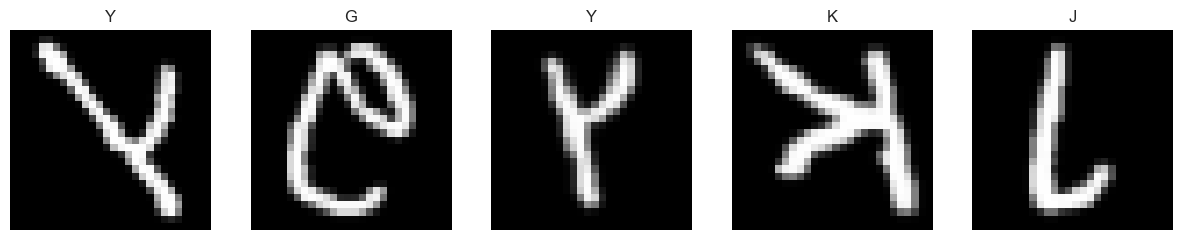

In [3]:

(ds_train, ds_test), ds_info = tfds.load('emnist/letters',
                                        split=['train','test'],
                                        as_supervised=True,
                                        with_info=True,
                                        batch_size=-1)

(x_train, y_train), (x_test, y_test) = [tfds.as_numpy(d) for d in (ds_train, ds_test)]

# Fix orientation
x_train = np.flip(x_train.transpose(0,2,1,3), axis=2).squeeze(-1)
x_test  = np.flip(x_test.transpose(0,2,1,3), axis=2).squeeze(-1)
y_train -= 1; y_test -= 1

print('Train:', x_train.shape, ' Test:', x_test.shape)

plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(chr(y_train[i]+65))
    plt.axis('off')
plt.show()


### Preprocessing for CNN

In [4]:

x_train = (x_train/255.0).astype('float32')[...,None]
x_test  = (x_test /255.0).astype('float32')[...,None]

y_train_oh = tf.keras.utils.to_categorical(y_train, 26)
y_test_oh  = tf.keras.utils.to_categorical(y_test, 26)

x_train, x_val, y_train_oh, y_val_oh = train_test_split(
    x_train, y_train_oh, test_size=0.2, random_state=42)

print('Train:', x_train.shape, ' Val:', x_val.shape)


Train: (71040, 28, 28, 1)  Val: (17760, 28, 28, 1)


## 2. CNN Model

In [5]:

def create_cnn(input_shape=(28,28,1), num_classes=26, dropout=0.3, lr=1e-3):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_cnn()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,418 (1.51 MB)

 Trainable params: 394,970 (1.51 MB)

 Non-trainable params: 448 (1.75 KB)

## 3. Training

In [6]:

cbs = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3),
    tf.keras.callbacks.ModelCheckpoint('models/emnist_cnn.keras',save_best_only=True)
]

hist = model.fit(x_train, y_train_oh,
                 validation_data=(x_val,y_val_oh),
                 epochs=20,
                 batch_size=256,
                 callbacks=cbs,
                 verbose=2)


Epoch 1/20
278/278 - 15s - 52ms/step - accuracy: 0.8157 - loss: 0.6006 - val_accuracy: 0.0497 - val_loss: 10.5359 - learning_rate: 1.0000e-03
Epoch 2/20
278/278 - 13s - 46ms/step - accuracy: 0.9127 - loss: 0.2629 - val_accuracy: 0.8810 - val_loss: 0.3519 - learning_rate: 1.0000e-03
Epoch 3/20
278/278 - 16s - 59ms/step - accuracy: 0.9284 - loss: 0.2107 - val_accuracy: 0.9325 - val_loss: 0.1944 - learning_rate: 1.0000e-03
Epoch 4/20
278/278 - 17s - 62ms/step - accuracy: 0.9382 - loss: 0.1776 - val_accuracy: 0.9365 - val_loss: 0.1833 - learning_rate: 1.0000e-03
Epoch 5/20
278/278 - 13s - 47ms/step - accuracy: 0.9432 - loss: 0.1596 - val_accuracy: 0.9389 - val_loss: 0.1808 - learning_rate: 1.0000e-03
Epoch 6/20
278/278 - 13s - 47ms/step - accuracy: 0.9480 - loss: 0.1431 - val_accuracy: 0.9420 - val_loss: 0.1748 - learning_rate: 1.0000e-03
Epoch 7/20
278/278 - 13s - 49ms/step - accuracy: 0.9514 - loss: 0.1306 - val_accuracy: 0.9384 - val_loss: 0.1972 - learning_rate: 1.0000e-03
Epoch 8/20
2

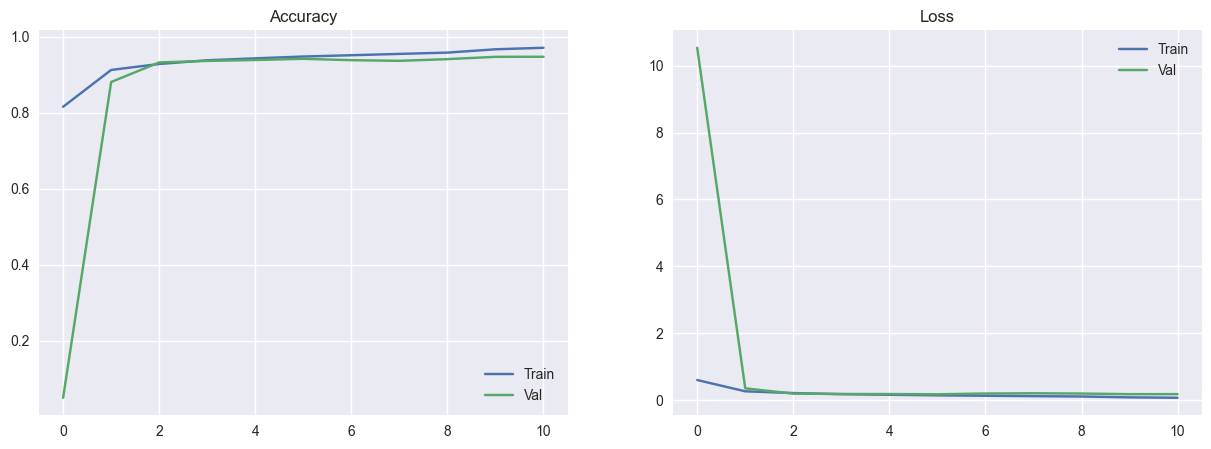

In [9]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(hist.history['accuracy'],label='Train')
ax1.plot(hist.history['val_accuracy'],label='Val')
ax1.set_title('Accuracy'); ax1.legend()

ax2.plot(hist.history['loss'],label='Train')
ax2.plot(hist.history['val_loss'],label='Val')
ax2.set_title('Loss'); ax2.legend()
plt.show()


## 4. Evaluation & Metrics

Test accuracy: 0.9301
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


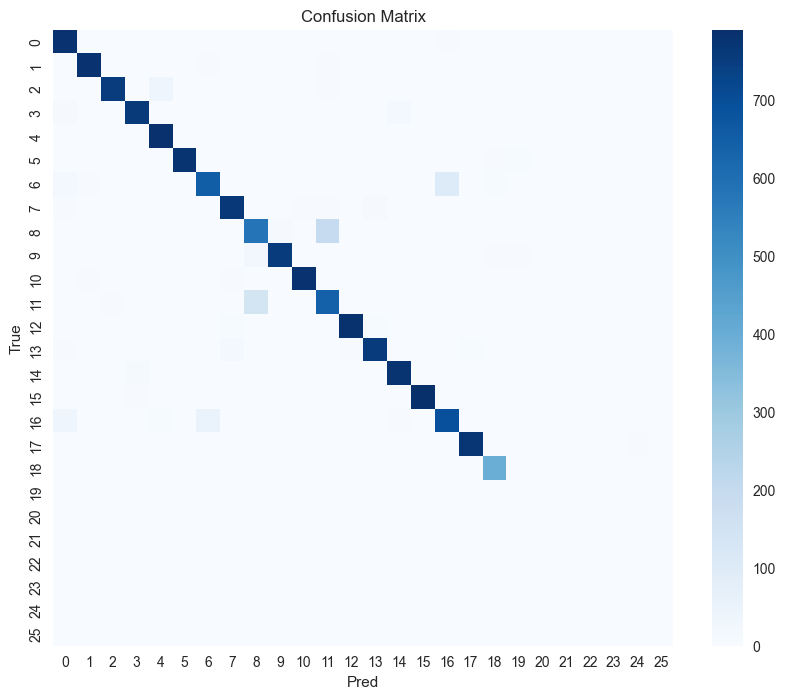

In [12]:

test_loss, test_acc = model.evaluate(x_test, y_test_oh, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')

y_pred = np.argmax(model.predict(x_test,batch_size=1024),axis=1)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
precision = report['weighted avg']['precision']
recall    = report['weighted avg']['recall']
f1        = report['weighted avg']['f1-score']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm,cmap='Blues',annot=False)
plt.title('Confusion Matrix'); plt.xlabel('Pred'); plt.ylabel('True')
plt.show()

metrics = {
    'model':'emnist_cnn',
    'accuracy':float(test_acc),
    'precision':float(precision),
    'recall':float(recall),
    'f1_score':float(f1),
    'confusion_matrix':cm.tolist()
}
with open('results/part_2/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")
